In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import nbimporter
from code_ import savgol_filter, read_csv_multi
import seaborn as sns
from itertools import product
import os

def compute_rmse(original, filtered):
    """
    Computes the RMSE between the original and filtered signal.
    """
    original = np.array(original)
    filtered = np.array(filtered)
    return np.sqrt(np.mean((filtered - original) ** 2))


Running RMSE grid search over multiple ECG files...

Window=3, PolyOrder=1 → Mean RNSE = 7.72 dB
Window=3, PolyOrder=2 → Mean RNSE = 0.00 dB
Window=5, PolyOrder=1 → Mean RNSE = 13.65 dB
Window=5, PolyOrder=2 → Mean RNSE = 5.06 dB
Window=5, PolyOrder=3 → Mean RNSE = 5.06 dB
Window=5, PolyOrder=4 → Mean RNSE = 0.00 dB
Window=7, PolyOrder=1 → Mean RNSE = 18.77 dB
Window=7, PolyOrder=2 → Mean RNSE = 8.58 dB
Window=7, PolyOrder=3 → Mean RNSE = 8.58 dB
Window=7, PolyOrder=4 → Mean RNSE = 4.13 dB
Window=7, PolyOrder=5 → Mean RNSE = 4.13 dB
Window=7, PolyOrder=6 → Mean RNSE = 0.00 dB
Window=9, PolyOrder=1 → Mean RNSE = 24.01 dB
Window=9, PolyOrder=2 → Mean RNSE = 11.06 dB
Window=9, PolyOrder=3 → Mean RNSE = 11.06 dB
Window=9, PolyOrder=4 → Mean RNSE = 6.93 dB
Window=9, PolyOrder=5 → Mean RNSE = 6.93 dB
Window=9, PolyOrder=6 → Mean RNSE = 3.62 dB
Window=9, PolyOrder=7 → Mean RNSE = 3.62 dB
Window=9, PolyOrder=8 → Mean RNSE = 0.00 dB
Window=11, PolyOrder=1 → Mean RNSE = 29.41 dB
Window=11, PolyO

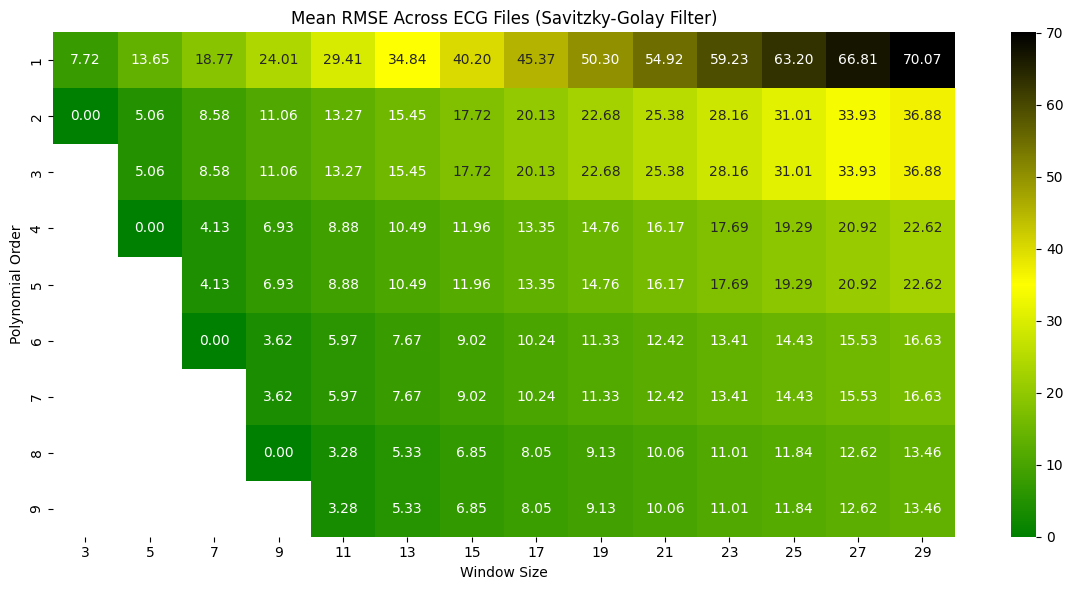

In [ ]:

ecg_dir = "ECGData"
window_sizes = list(range(3, 31, 2))   
poly_orders = list(range(1, 10)) 
use_subset = True
max_files = 1000 
from matplotlib.colors import LinearSegmentedColormap


all_files = [os.path.join(ecg_dir, f) for f in os.listdir(ecg_dir) if f.endswith('.csv')]
if use_subset:
    all_files = all_files[:max_files]

results = {}

print("Running RMSE grid search over multiple ECG files...\n")

for w, p in product(window_sizes, poly_orders):
    if p >= w:
        continue
    file_rmse = []
    for filepath in all_files:
        try:
            channels = read_csv_multi(filepath)
            test_channels = [ch[:2000] for ch in channels[:3]] if use_subset else channels
            rmsee = []
            for channel in test_channels:
                filtered = savgol_filter(channel, w, p)
                rmse = compute_rmse(channel, filtered)
                rmsee.append(rmse)
            file_rmse.append(np.mean(rmsee))
        except Exception as e:
            print(f"Failed on {filepath}: {e}")
            continue
    if file_rmse:
        overall_mean_rmse = np.mean(file_rmse)
        results[(w, p)] = overall_mean_rmse
        print(f"Window={w}, PolyOrder={p} → Mean RNSE = {overall_mean_rmse:.2f} dB")


best_combo = max(results.items(), key=lambda x: x[1])
best_window, best_poly = best_combo[0]
best_rmse= best_combo[1]
print(f"\nBest overall filter: window={best_window}, poly_order={best_poly}, mean RMSE={best_rmse:.2f} dB")

custom_cmap = LinearSegmentedColormap.from_list("green_yellow_black", ["green", "yellow", "black"])
heatmap_matrix = np.full((len(poly_orders), len(window_sizes)), np.nan)
for i, p in enumerate(poly_orders):
    for j, w in enumerate(window_sizes):
        if (w, p) in results:
            heatmap_matrix[i, j] = results[(w, p)]

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_matrix, annot=True, fmt=".2f", cmap=custom_cmap ,
            xticklabels=window_sizes, yticklabels=poly_orders)
plt.title("Mean RMSE Across ECG Files (Savitzky-Golay Filter)")
plt.xlabel("Window Size")
plt.ylabel("Polynomial Order")
plt.tight_layout()
plt.show()